# Your feedback


**Your feedback is important to me!**
If you haven't yet, **please** (please!!!), fill the [Week 5 - Mid-term Feedback Form](https://learn.inside.dtu.dk/d2l/lms/survey/user/attempt/survey_start_frame.d2l?si=31326&ou=242061) on DTU Learn. It only takes few minutes. 



# Overview

In this class, we will learn more about networks. You will get an overview of concepts such as Assortativity, Centrality and Communities.
The lecture is structured as follows.

* __Part 1__: Learn about Centrality and Assortativity through a lecture. Apply the concepts to undertand a bit more about the structure of our network of Computational Social Scientists.  
* __Part 2__: Learn about Community Detection with a lecture and an exercise related to the famous [Zachary Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). Then, apply what you have learned to study the network of Computational Social Scientists.


# Part 1: Centrality and Assortativity

We will start by learning about some advanced concepts in network science: Centrality and Assortativity. Then, we will apply these concepts to learn a bit more about our network of scientsits. 

> **_Video lecture:_** [Network measures.](https://youtu.be/a_J5lV4KT3Q)
>
> **_Reading_**: Learn about assortativity by reading [Chapter 7](http://networksciencebook.com/chapter/7#introduction7). The important parts are in sections [7.2](http://networksciencebook.com/chapter/7#assortativity) and [7.3](http://networksciencebook.com/chapter/7#measuring-degree).

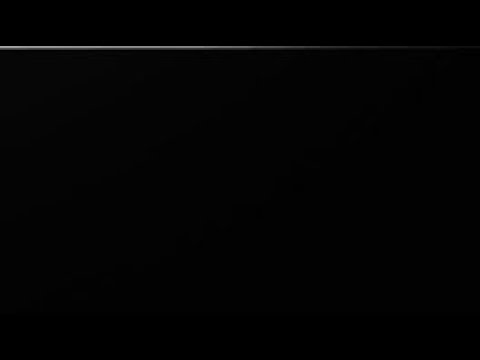

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("a_J5lV4KT3Q", width=600)

# Network Analysis in Computational Social Science

This week, we'll delve deeper into the network of Computational Social Scientists, focusing on advanced network features. If your network is composed of multiple components, concentrate on the giant connected component (GCC) for the exercises below. Utilize the network constructed in [Week 4](https://nbviewer.org/github/TheYuanLiao/comsocsci2025/blob/main/lectures/Week4.ipynb).

> __Exercise 1: Mixing Patterns and Assortativity__  
>
> __Part 1: Assortativity Coefficient__ 
> 1. *Calculate the Assortativity Coefficient* for the network based on the country of each node. Implement the calculation using the formula provided during the lecture, also available in [this paper](https://arxiv.org/pdf/cond-mat/0209450.pdf) (equation 2, here for directed networks). **Do not use the NetworkX implementation.**
>

In [5]:
import networkx as nx
import pandas as pd
import numpy as np
from collections import defaultdict
%matplotlib inline

researchers_graph = nx.Graph()

edgelist_df = pd.read_csv("files/weighted_edgelist.csv")

# Tilføj vægtede kanter fra edgelisten
researchers_graph.add_weighted_edges_from(edgelist_df.itertuples(index=False, name=None))

# Udskriv grundlæggende information om grafen
print(f"Antal noder: {researchers_graph.number_of_nodes()}")
print(f"Antal kanter: {researchers_graph.number_of_edges()}")

Antal noder: 16190
Antal kanter: 65448


In [ ]:
papers_df = pd.read_csv("files/combined_papers_filtered.csv")

author_citations = defaultdict(int)
author_first_pub_year = defaultdict(lambda: float('inf'))

for _, row in papers_df.iterrows():
    publication_year = row["publication_year"]
    for author_id in row["author_ids"]:
        author_citations[author_id] += row["cited_by_count"]
        if publication_year < author_first_pub_year[author_id]:
            author_first_pub_year[author_id] = publication_year

# Replace 'inf' with None if no publication year found
author_first_pub_year = {k: (v if v != float('inf') else None) for k, v in author_first_pub_year.items()}

authors_df = pd.read_csv("files/authors_combined.csv")
# Iterate through authors in the authors dataframe
for _, author in authors_df.iterrows():
    author_id = author["ID"]
    
    if author_id in researchers_graph.nodes:
        researchers_graph.nodes[author_id]["name"] = author["Name"]
        researchers_graph.nodes[author_id]["country"] = author["Country Code"]
        researchers_graph.nodes[author_id]["citation_count"] = author_citations.get(author_id, 0)
        researchers_graph.nodes[author_id]["first_publication_year"] = author_first_pub_year.get(author_id, None)

In [10]:
def calculate_assortativity(G, attribute='country'):
    """
    Calculate assortativity coefficient based on the provided formula
    
    Parameters:
    G (networkx.Graph): Graph containing nodes with attributes
    attribute (str): Node attribute to measure assortativity (default: 'country')
    
    Returns:
    float: Assortativity coefficient r
    """
    # Get all unique attribute values
    attr_values = set()
    for node in G.nodes():
        if attribute in G.nodes[node]:
            attr_values.add(G.nodes[node][attribute])
    attr_values = list(attr_values)
    
    # Map attribute values to indices
    attr_to_idx = {val: i for i, val in enumerate(attr_values)}
    num_types = len(attr_values)
    
    # Initialize matrices for calculations
    e_matrix = np.zeros((num_types, num_types))
    total_edges = G.number_of_edges()
    
    # Count edges between each type
    for u, v in G.edges():
        # Skip if nodes don't have the attribute
        if attribute not in G.nodes[u] or attribute not in G.nodes[v]:
            continue
            
        u_type = attr_to_idx[G.nodes[u][attribute]]
        v_type = attr_to_idx[G.nodes[v][attribute]]
        
        # For undirected graphs, add edge in both directions
        e_matrix[u_type][v_type] += 1/total_edges
        if not G.is_directed():
            e_matrix[v_type][u_type] += 1/total_edges
    
    # For undirected graphs, normalize by dividing by 2
    if not G.is_directed():
        e_matrix = e_matrix / 2
    
    # Calculate a_μ (fraction of edges attached to nodes of type μ)
    a = np.sum(e_matrix, axis=1)  # Sum rows
    
    # Calculate Σ_μ e_μμ (sum of diagonal elements)
    sum_e_mu_mu = np.trace(e_matrix)
    
    # Calculate Σ_μ a_μ*a_μ
    sum_a_mu_squared = np.sum(a * a)
    
    # Calculate r according to the formula
    numerator = sum_e_mu_mu - sum_a_mu_squared
    denominator = 1 - sum_a_mu_squared
    
    # Avoid division by zero
    if abs(denominator) < 1e-10:
        return 0.0
        
    r = numerator / denominator
    return r.item()

print(f"The Assortativity Coefficient* for the network based on the country of each node is: \n {calculate_assortativity(researchers_graph, 'country')}")

The Assortativity Coefficient* for the network based on the country of each node is: 
 0.37649271981458204


> __Part 2: Configuration model__
> In the following, we are going to assess the significance of the assortativity by comparing the network's assortativity coefficient against that of random networks generated through the configuration model.  
>
> 2. *Implement the configuration model* using the _double edge swap_ algorithm to generate random networks. Ensure each node retains its original degree but with altered connections. Create a function that does that by following these steps:
>   - **a.** Create an exact copy of your original network.
>   - **b.** Select two edges, $e_{1} = (u,v)$ and $e_{2} = (x,y)$, ensuring *u != y* and *v != x*.
>   - **c.** Flip the direction of $e_{1}$ to $e_{1} = (v,u)$ 50% of the time. This ensure that your final results is not biased, in case your edges were sorted (they usually are). 
>   - **d.** Ensure that new edges $e_{1}' = (e_{1}[0],e_{2}[1])$ and $e_{2}' = (e_{2}[0],e_{1}[1])$ do not already exist in the network.
>   - **e.** Remove edges $e_{1}$ and $e_{2}$ and add edges $e_{1}'$ and $e_{2}'$.
>   - **f.** Repeat steps **b** to **e** until you have performed _E*10_ swaps, where E is the total number of edges.

> 3. *Double check that your algorithm works well*, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.

In [12]:
random_graph = nx.Graph(researchers_graph)
    
# Calculate number of swaps to perform if not provided
E = random_graph.number_of_edges()
num_swaps = E * 10

random_graph = nx.double_edge_swap(random_graph, nswap=num_swaps, max_tries=num_swaps*100)

In [13]:
# Check all nodes exist in both graphs
original_nodes = set(researchers_graph.nodes())
random_nodes = set(random_graph.nodes())
same_nodes = original_nodes == random_nodes

if not same_nodes:
    print("Node sets differ between graphs!")
    print("Nodes in original but not random:", original_nodes - random_nodes)
    print("Nodes in random but not original:", random_nodes - original_nodes)

# Check all degrees match
degrees_match = True
for node in original_nodes:
    if researchers_graph.degree(node) != random_graph.degree(node):
        print(f"Degree mismatch: Node {node} has degree {researchers_graph.degree(node)} in original but {random_graph.degree(node)} in random")
        degrees_match = False
        break

print("Valid randomization:", same_nodes and degrees_match)

Valid randomization: True


> __Part 3: Analyzing Assortativity in Random Networks__  
>
> 4. *Generate and analyze at least 100 random networks* using the configuration model. For each, calculate the assortativity with respect to the country and plot the distribution of these values. Compare the results with the assortativity of your original network to determine if connections within the same country are significantly higher than chance.

In [ ]:
import random

def our_configuration_model(G, num_swaps=None):
    # Step a: Create an exact copy of the original network
    G_random = nx.Graph(G)
    
    # Calculate number of swaps to perform if not provided
    E = G_random.number_of_edges()
    if num_swaps is None:
        num_swaps = E * 10
    
    # Track successful swaps
    successful_swaps = 0
    attempts = 0
    max_attempts = num_swaps * 10  # Prevent infinite loops
    
    while successful_swaps < num_swaps and attempts < max_attempts:
        attempts += 1
        
        # Step b: Select two random edges
        if len(list(G_random.edges())) < 2:
            break  # Not enough edges to swap
            
        edges = list(G_random.edges())
        e1 = random.choice(edges)
        e2 = random.choice(edges)
        
        # Skip if we selected the same edge twice
        if e1 == e2:
            continue
            
        u, v = e1
        x, y = e2
        
        # Skip if the nodes are the same or already connected
        if u == x or u == y or v == x or v == y:
            continue
            
        # Step c: Flip direction of e1 with 50% probability
        if random.random() < 0.5:
            u, v = v, u  # Flip direction
            
        # Step d: Check if new edges already exist
        if G_random.has_edge(u, y) or G_random.has_edge(x, v):
            continue
            
        # Step e: Remove old edges and add new ones
        G_random.remove_edge(u, v)
        G_random.remove_edge(x, y)
        G_random.add_edge(u, y)
        G_random.add_edge(x, v)
        
        successful_swaps += 1
    
    # Check if we've reached the target number of swaps
    if successful_swaps < num_swaps:
        print(f"Warning: Only completed {successful_swaps}/{num_swaps} swaps after {attempts} attempts")
    
    return G_random

In [14]:
random_assortativities = []
for _ in range(100):
    random_graph = nx.double_edge_swap(random_graph, nswap=num_swaps, max_tries=num_swaps*100)
    random_assortativities.append(calculate_assortativity(random_graph, 'country'))

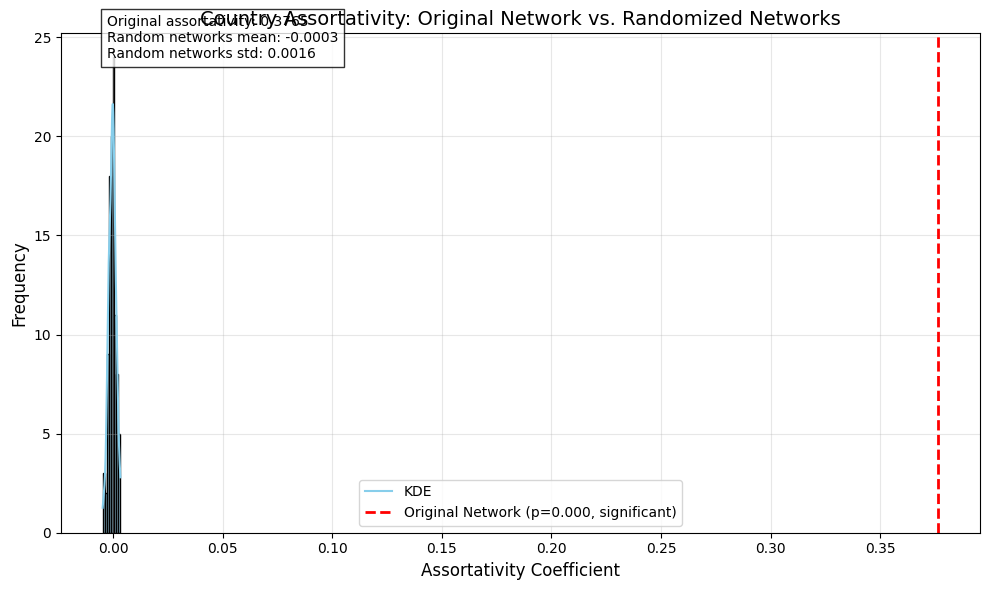

Original network assortativity: 0.3765
Randomized networks mean assortativity: -0.0003 ± 0.0016
P-value: 0.0000
The country assortativity in the original network is significantly higher than expected by chance.
Z-score: 229.9067


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

original_assortativity = calculate_assortativity(researchers_graph, 'country')

# Create the visualization
plt.figure(figsize=(10, 6))

# Use Seaborn for a nicer histogram
sns.histplot(random_assortativities, kde=True, color='skyblue', alpha=0.7)

# Add a vertical line for the original network's assortativity
plt.axvline(x=original_assortativity, color='red', linestyle='--', linewidth=2)

# Add text annotation
mean_random = np.mean(random_assortativities)
std_random = np.std(random_assortativities)
plt.text(0.05, 0.95, f"Original assortativity: {original_assortativity:.4f}\n"
                     f"Random networks mean: {mean_random:.4f}\n"
                     f"Random networks std: {std_random:.4f}", 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

# Calculate the p-value
p_value = sum(r >= original_assortativity for r in random_assortativities) / len(random_assortativities)
significance_text = "significant" if p_value < 0.05 else "not significant"

# Add more context
plt.title("Country Assortativity: Original Network vs. Randomized Networks", fontsize=14)
plt.xlabel("Assortativity Coefficient", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(alpha=0.3)

# Add legend
plt.legend(['KDE', f'Original Network (p={p_value:.3f}, {significance_text})'])

# Improve layout
plt.tight_layout()

# Save the figure
plt.savefig("assortativity_comparison.png", dpi=300)
plt.show()

# Print statistical summary
print(f"Original network assortativity: {original_assortativity:.4f}")
print(f"Randomized networks mean assortativity: {mean_random:.4f} ± {std_random:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("The country assortativity in the original network is significantly higher than expected by chance.")
else:
    print("The country assortativity in the original network is not significantly different from what would be expected by chance.")

# Calculate Z-score
z_score = (original_assortativity - mean_random) / std_random
print(f"Z-score: {z_score:.4f}")

> __Part 4: Assortativity by Degree__
>
> 5. *Calculate degree assortativity* for your network using the formula discussed in the lecture.

In [17]:
degree_assortativity = nx.degree_assortativity_coefficient(researchers_graph)
print(f"Degree assortativity coefficient: {degree_assortativity:.4f}")

Degree assortativity coefficient: -0.0820


The coefficient is close to 0, which means that the connections are independent of degree. In other words, there is no particular relationship between the collaboration network sizes of co-authors. Authors with many collaborators are just as likely to work with less-connected authors as with highly-connected ones.

> 6. *Compare your network's degree assortativity* against that of 100 random networks generated via the configuration model. Analyze whether your network shows a tendency for high-degree scientists to connect with other high-degree scientists and vice versa. 

In [20]:
def create_random_graphs(original, n_random):
    random_graphs = []
    for i in range(n_random):
        # Create a fresh copy of the original graph
        random_graph = original.copy()
        
        # Calculate number of swaps
        num_edges = random_graph.number_of_edges()
        num_swaps = int(num_edges * 10)
        
        # Perform double edge swap
        random_graphs.append(nx.double_edge_swap(random_graph, nswap=num_swaps, max_tries=num_swaps*10))

        # Print progress
        if (i+1) % 10 == 0:
            print(f"Completed {i+1}/{n_random} randomized networks")
    
    return random_graphs

random_graphs = create_random_graphs(researchers_graph, 100)

Completed 10/100 randomized networks
Completed 20/100 randomized networks
Completed 30/100 randomized networks
Completed 40/100 randomized networks
Completed 50/100 randomized networks
Completed 60/100 randomized networks
Completed 70/100 randomized networks
Completed 80/100 randomized networks
Completed 90/100 randomized networks
Completed 100/100 randomized networks


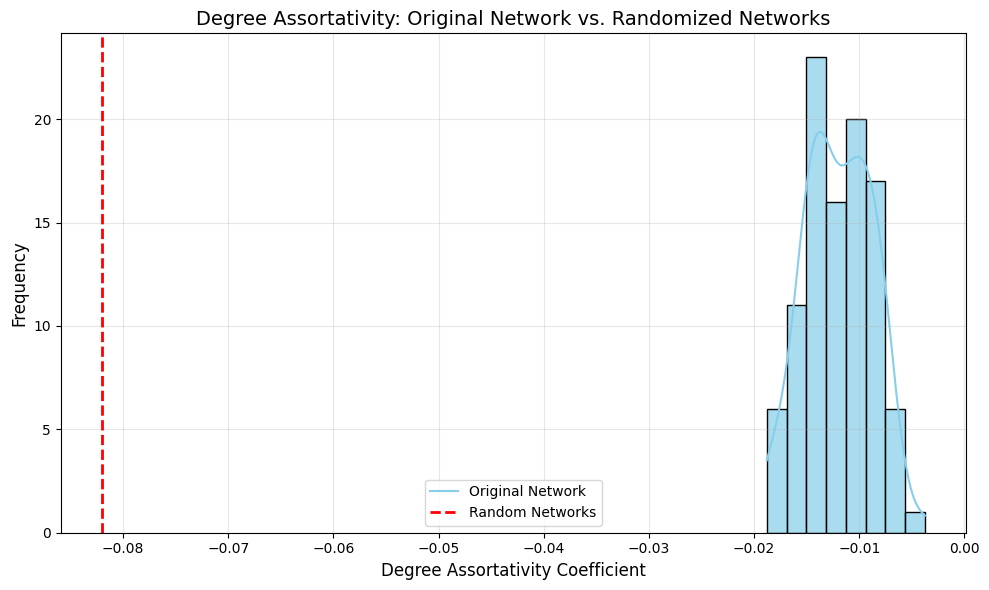

In [21]:
random_degree_assortativities = []

for random_graph in random_graphs:
    random_assortativity = nx.degree_assortativity_coefficient(random_graph)
    random_degree_assortativities.append(random_assortativity)

# Create visualization to compare
plt.figure(figsize=(10, 6))

# Plot the distribution of random network values
sns.histplot(random_degree_assortativities, kde=True, color='skyblue', alpha=0.7)

# Add vertical line for original network
plt.axvline(x=degree_assortativity, color='red', linestyle='--', linewidth=2)

# Add labels and title
plt.title("Degree Assortativity: Original Network vs. Randomized Networks", fontsize=14)
plt.xlabel("Degree Assortativity Coefficient", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(['Original Network', 'Random Networks'])

# Improve layout
plt.tight_layout()

# Save the figure
plt.savefig("degree_assortativity_comparison.png", dpi=300)
plt.show()

> __Part 5: Reflection questions__    
> 7. *Assortativity by degree.* Were the results of the degree assortativity in line with your expectations? Why or why not?   

- We expected the degree assortativity to be positive, such that authors with high number of collaborators would also tend to collaborate with other high collaborating authors. However the assortativity by degree was close to 0, meaning that there doesn't exist such a dependency.

> 8. *Edge flipping.* In the process of implementing the configuration model, you were instructed to flip the edges (e.g., changing *e_1* from (u,v) to (v,u)) 50% of the time. Why do you think this step is included?    

- To introduce more randomness, and reduce possible biases in the random network.

> 9. *Distribution of assortativity in random networks.* Describe the distribution of degree assortativity values you observed for the random 
networks. Was the distribution pattern expected? Discuss how the nature of random network generation (specifically, the configuration model and edge flipping) might influence this distribution and whether it aligns with theoretical expectations.    

- The distribution of degree assortativity in the random networks was normally distributed around 0, which is expected since random networks created by the configuration model shouldn't show any preference for connections between similar-degree nodes. In random networks that only preserve the degree distribution, high-degree nodes connect to low-degree nodes just as often as to other high-degree nodes, creating assortativity values near zero.
The bell-shaped distribution shows that our randomization process is working correctly. The configuration model randomizes connections while keeping each node's degree the same, and the edge flipping step prevents bias from the original edge ordering. Without edge flipping, some patterns from the original network might remain, affecting the distribution.
This distribution gives us a baseline to compare our original network against, helping us determine if the connection patterns we see are significant or could happen by chance.


> **Exercise 2: Central nodes.** Remember to write your answers in the notebook. 
> * Find the 5 most central scientists according to the closeness centrality. What role do you imagine scientists with high closeness centrality play? 
> * Find the 5 most central scientists according to eigenvector centrality.     
> * Plot the closeness centrality of nodes vs their degree. Is there a correlation between the two? Did you expect that? Why?    
> * Repeat the two points above using eigenvector centrality instead. Do you observe any difference? Why?

In [32]:
closeness_dict = nx.closeness_centrality(researchers_graph)

In [33]:
eigenvector_centrality = nx.eigenvector_centrality(researchers_graph)

In [34]:
# Get top 5 researchers by closeness centrality
top_researchers_closeness = sorted(closeness_dict.items(), key=lambda x: x[1], reverse=True)[:5]
for researcher, score in top_researchers_closeness:
    print(f"Researcher: {researchers_graph.nodes[researcher]['name']}, Closeness Score: {score:.4f}")

print("\n")
# Get top 5 researchers by eigenvector centrality
top_researchers_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
for researcher, score in top_researchers_eigenvector:
    print(f"Researcher: {researchers_graph.nodes[researcher]['name']}, Eigenvector Score: {score:.4f}")

Researcher: Alex Pentland, Closeness Score: 0.2676
Researcher: Eric Horvitz, Closeness Score: 0.2619
Researcher: Joshua B. Tenenbaum, Closeness Score: 0.2570
Researcher: Thomas L. Griffiths, Closeness Score: 0.2565
Researcher: Jure Leskovec, Closeness Score: 0.2533


Researcher: Yi Yang, Eigenvector Score: 0.4482
Researcher: Nicu Sebe, Eigenvector Score: 0.1623
Researcher: Shuicheng Yan, Eigenvector Score: 0.1564
Researcher: Yan Wang, Eigenvector Score: 0.1546
Researcher: Meng Wang, Eigenvector Score: 0.1233


The 

In [35]:
print(f"Antal noder: {researchers_graph.number_of_nodes()}")
print(f"Antal kanter: {researchers_graph.number_of_edges()}")

Antal noder: 16190
Antal kanter: 65448


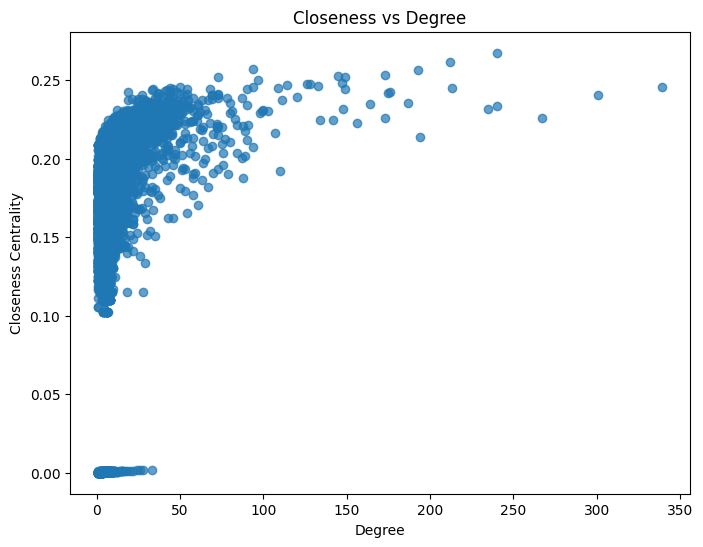

Korrelation mellem degree og closeness: 0.255


In [36]:
# 2. Hent grader for hver node (G.degree() returnerer (node, degree)-par)
degree_dict = dict(researchers_graph.degree())

# 3. Opret lister til plotting
nodes = list(researchers_graph.nodes())
x = [degree_dict[n] for n in nodes]          # grader
y = [closeness_dict[n] for n in nodes]       # closeness-værdier

# 4. Plot scatter
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Closeness Centrality')
plt.title('Closeness vs Degree')
plt.show()

# 5. (Valgfrit) Beregn korrelation
corr_matrix = np.corrcoef(x, y)
corr = corr_matrix[0, 1]
print(f"Korrelation mellem degree og closeness: {corr:.3f}")

This moderate correlation makes sense for several reasons:

- Scientists with many collaborators (high degree) might have some advantage in reaching others quickly, but this isn't guaranteed
- A strategically positioned researcher with fewer but well-placed connections might have higher closeness than someone with many connections in a single cluster
- The collaboration network likely contains distinct research communities, where cross-community connectors might have moderate degree but high closeness
- Some high-degree researchers might be central within their immediate research area but relatively isolated from other research communities

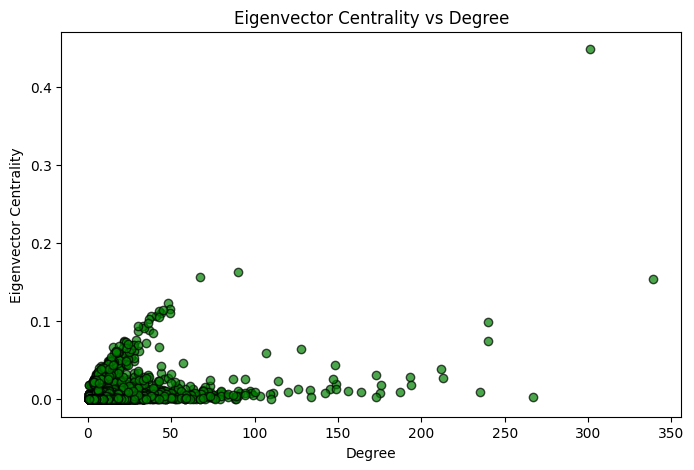

Korrelation mellem degree og eigenvector centrality: 0.404


In [37]:
# x-akse: degree, y-akse: eigenvector centrality
x_vals = [degree_dict[n] for n in nodes]
y_vals = [eigenvector_centrality[n] for n in nodes]

plt.figure(figsize=(8, 5))
plt.scatter(x_vals, y_vals, alpha=0.7, color='green', edgecolor='black')
plt.xlabel("Degree")
plt.ylabel("Eigenvector Centrality")
plt.title("Eigenvector Centrality vs Degree")
plt.show()

# 4) (Valgfrit) Beregn Pearson-korrelation
corr_matrix = np.corrcoef(x_vals, y_vals)
corr = corr_matrix[0, 1]
print(f"Korrelation mellem degree og eigenvector centrality: {corr:.3f}")

# Part 2: Community detection.

We will continue the analysis of our network of Computational Social Scientists.
We will start by learning about community detection with a lecture from my colleague Sune Lehmann.

> **_Video Lecture_**: Communities in networks. 


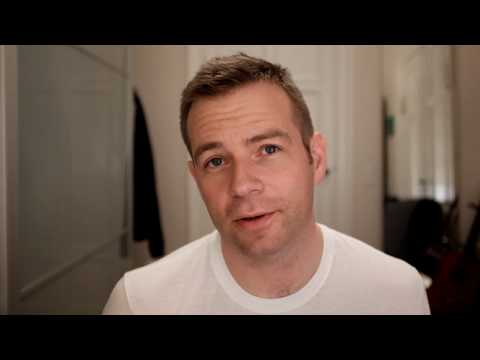

In [44]:
from IPython.display import YouTubeVideo
YouTubeVideo("FSRoqXw28RI",width=800, height=450)

> **_Reading_**: [Chapter 9 of the NS book.](http://networksciencebook.com/chapter/9). You can skip sections 9.3, 9.5 and 9.7. 



> __Exercise 3: Zachary's karate club__: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable//auto_examples/graph/plot_karate_club.html) 
>
> 1. Visualize the graph. Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.

<img src="https://github.com/lalessan/comsocsci2021/raw/master/files/karate.png" alt="Drawing" style="width: 800px;"/>

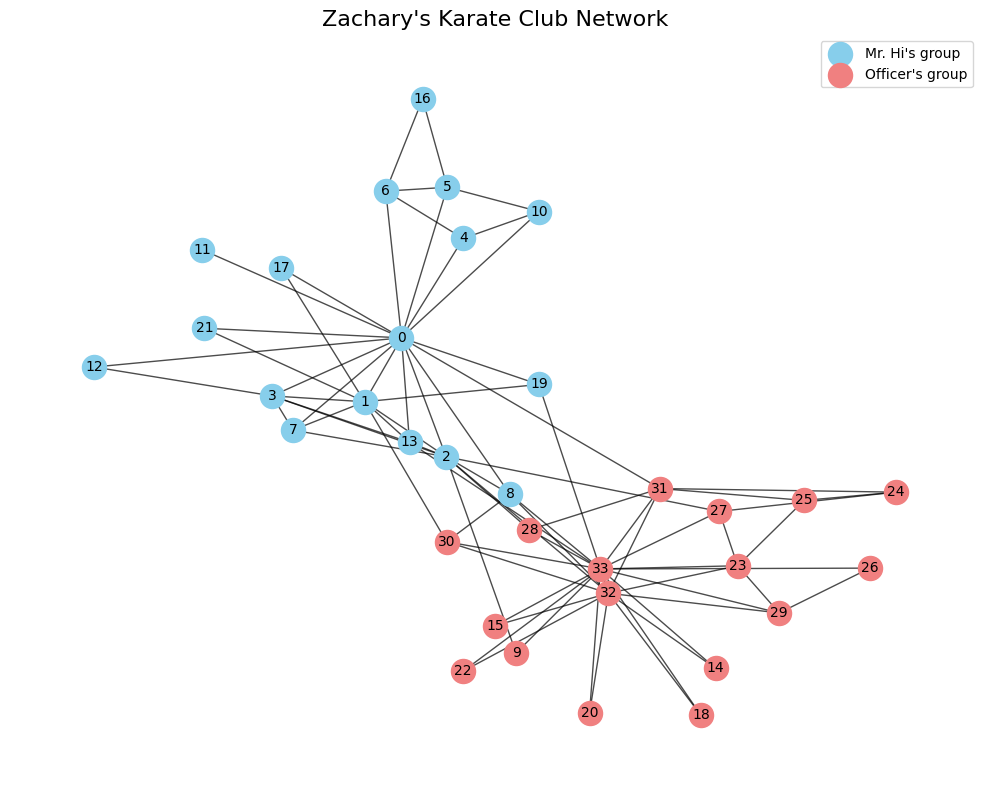

In [45]:
import networkx as nx
import matplotlib.pyplot as plt

# Load Zachary's Karate Club graph
G_karate = nx.karate_club_graph()

# Extract club information
club1_nodes = []
club2_nodes = []

for node, club in nx.get_node_attributes(G_karate, 'club').items():
    if club == 'Mr. Hi':
        club1_nodes.append(node)
    else:  # club == 'Officer'
        club2_nodes.append(node)

# Set up the visualization
plt.figure(figsize=(10, 8))

# Create a layout for our nodes
pos = nx.spring_layout(G_karate, seed=42)  # Seed for reproducibility

# Draw the nodes
nx.draw_networkx_nodes(G_karate, pos, nodelist=club1_nodes, node_color='skyblue', 
                      node_size=300, label="Mr. Hi's group")
nx.draw_networkx_nodes(G_karate, pos, nodelist=club2_nodes, node_color='lightcoral', 
                      node_size=300, label="Officer's group")

# Draw the edges
nx.draw_networkx_edges(G_karate, pos, width=1.0, alpha=0.7)

# Draw the labels
nx.draw_networkx_labels(G_karate, pos, font_size=10, font_family='sans-serif')

# Add a title and legend
plt.title("Zachary's Karate Club Network", fontsize=16)
plt.legend()

# Remove axis
plt.axis('off')

# Show the graph
plt.tight_layout()
plt.savefig('karate_club_visualization.png', dpi=300)
plt.show()

> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.

In [59]:
def calculate_modularity(G, communities):
    """
    Calculate modularity of a graph partition using the formula:
    M = sum_c [ (L_c/L) - (k_c/2L)^2 ]
    
    Parameters:
    -----------
    G : networkx.Graph
        The input graph
    communities : list of lists
        List where each element is a list of nodes in a community
    
    Returns:
    --------
    M : float
        The modularity value
    """
    # Total number of edges
    L = G.number_of_edges()
    
    # Initialize modularity
    M = 0
    
    # For each community c
    for community in communities:
        # Create a subgraph for this community
        subgraph = G.subgraph(community)
        
        # L_c: number of edges within community c
        L_c = subgraph.number_of_edges()
        
        # k_c: sum of degrees of nodes in community c
        k_c = sum(G.degree(node) for node in community)
        
        # Add this community's contribution to modularity
        M += (L_c / L) - ((k_c / (2 * L)) ** 2)
    
    return M

In [60]:
# Create communities based on the 'club' attribute
def get_communities(G):
    communities = []
    club1 = []
    club2 = []

    for node, club in nx.get_node_attributes(G, 'club').items():
        if club == 'Mr. Hi':
            club1.append(node)
        else:  # club == 'Officer'
            club2.append(node)

    communities = [club1, club2]
    return communities

> 3. Explain in your own words the concept of _modularity_. 

Modularity measures how well a network is divided into communities. When a network has high modularity, nodes within the same community connect to each other more than to nodes in other communities and the community structure is stronger than what random chance would create

> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.

In [61]:
# Calculate modularity
mod = calculate_modularity(G_karate, get_communities(G_karate))
print(f"Modularity of the club split: {mod:.4f}")

Modularity of the club split: 0.3582


> 5. Create $1000$ randomized version of the Karate Club network using the _double edge swap_ algorithm you wrote in the exercise above 5. For each of them, compute the modularity of the "club" split and store it in a list.

In [62]:
random_karate_graphs = create_random_graphs(G_karate, 1000)
karate_modularities = [calculate_modularity(G, get_communities(G)) for G in random_karate_graphs]

Completed 10/1000 randomized networks
Completed 20/1000 randomized networks
Completed 30/1000 randomized networks
Completed 40/1000 randomized networks
Completed 50/1000 randomized networks
Completed 60/1000 randomized networks
Completed 70/1000 randomized networks
Completed 80/1000 randomized networks
Completed 90/1000 randomized networks
Completed 100/1000 randomized networks
Completed 110/1000 randomized networks
Completed 120/1000 randomized networks
Completed 130/1000 randomized networks
Completed 140/1000 randomized networks
Completed 150/1000 randomized networks
Completed 160/1000 randomized networks
Completed 170/1000 randomized networks
Completed 180/1000 randomized networks
Completed 190/1000 randomized networks
Completed 200/1000 randomized networks
Completed 210/1000 randomized networks
Completed 220/1000 randomized networks
Completed 230/1000 randomized networks
Completed 240/1000 randomized networks
Completed 250/1000 randomized networks
Completed 260/1000 randomized netw

> 6. Compute the average and standard deviation of the modularity for the random network.

In [63]:
average_modularity = np.mean(karate_modularities)
std_modularity = np.std(karate_modularities)
average_modularity, std_modularity

(np.float64(-0.015739644970414263), np.float64(0.04971169344815397))

> 7. Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 

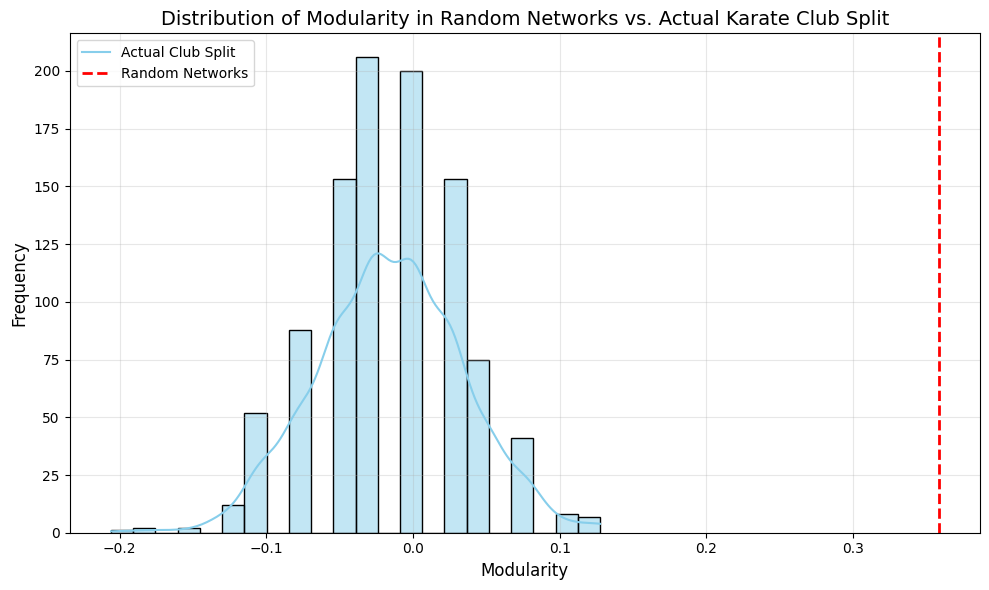

Actual modularity of karate club split: 0.3582
Mean modularity of random networks: -0.0157


In [64]:
plt.figure(figsize=(10, 6))

# Create histogram with kernel density estimate
sns.histplot(karate_modularities, kde=True, color='skyblue')

# Add vertical line for actual modularity
plt.axvline(x=mod, color='red', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel('Modularity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Modularity in Random Networks vs. Actual Karate Club Split', fontsize=14)

# Add legend
plt.legend(['Actual Club Split', 'Random Networks'])

# Add grid for better readability
plt.grid(alpha=0.3)

# Improve layout
plt.tight_layout()

# Save the figure
plt.savefig("karate_modularity_comparison.png", dpi=300)

# Show plot
plt.show()

# Print the actual modularity value
print(f"Actual modularity of karate club split: {mod:.4f}")
print(f"Mean modularity of random networks: {sum(karate_modularities)/len(karate_modularities):.4f}")

> 8. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?

The actual club split (red dashed line at ~0.37) has a modularity value much higher than any of the random networks, which mostly cluster around 0. This indicates that the club split is a good partitioning, better than would occur by random chance.

By creating many random networks and measuring their modularity, we establish a null distribution that shows what modularity values would be expected by chance alone

Preserving the node degrees during randomization was needed because it creates a fair comparison. By keeping each node's number of connections the same while randomizing who they connect to, we're testing whether the specific pattern of connections (who connects to whom) matters, not just how many connections exist.

> 9.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?

In [65]:
import community as community_louvain

partition = community_louvain.best_partition(G_karate)
# Calculate the modularity of this partition
modularity = community_louvain.modularity(partition, G_karate)
print(f"Modularity found by Louvain algorithm: {modularity:.4f}")

Modularity found by Louvain algorithm: 0.4345


The modularity is higher than what we found above.

The Louvain algorithm found a modularity value higher than the actual club split (0.37). This reveals that while the real-world division of the karate club reflected genuine community structure, it wasn't necessarily the optimal division from a purely network perspective.

Network algorithms can sometimes detect more mathematically optimal divisions than what emerges naturally in social settings

The actual club split was likely influenced by factors beyond just network connections, such as personal loyalties or events not captured in the network data

> 10.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

In [66]:
# Get the club split information
club_split = {}
for node, club in nx.get_node_attributes(G_karate, 'club').items():
    if club == 'Mr. Hi':
        club_split[node] = 0  # Mr. Hi's group
    else:
        club_split[node] = 1  # Officer's group

# Get the Louvain communities
louvain_communities = partition  # from your previous code

# Find number of Louvain communities
num_louvain = len(set(louvain_communities.values()))

# Create the confusion matrix
confusion_matrix = np.zeros((num_louvain, 2), dtype=int)

# Fill the confusion matrix
for node in G_karate.nodes():
    louvain_group = louvain_communities[node]
    club_group = club_split[node]
    confusion_matrix[louvain_group, club_group] += 1

# Create a nice DataFrame for display
club_names = ["Mr. Hi's group", "Officer's group"]
louvain_names = [f"Louvain Community {i}" for i in range(num_louvain)]
confusion_df = pd.DataFrame(confusion_matrix, index=louvain_names, columns=club_names)

print("Confusion Matrix:")
print(confusion_df)

Confusion Matrix:
                     Mr. Hi's group  Officer's group
Louvain Community 0               5                0
Louvain Community 1              11                0
Louvain Community 2               1               17


> __Exercise 4__: Community detection on the network of Computational Social Scientists. 
>
> * Consider the network of Computational Social Scientists. 
> * Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0? 
> * If you are curious, you can also try the *Infomap* algorithm. Go to [this page]. (https://mapequation.github.io/infomap/python/). It's harder to install, but a better community detection algorithm. You can read about it in [advanced topics 9B](http://networksciencebook.com/chapter/9#advanced-9b).
> * Visualize the network, using netwulf (see Week 5). This time assign each node a different color based on their _community_. Describe the structure you observe.
> * Make sure you save the assignment of authors to communities.


Modularity found by Louvain algorithm: 0.8298
Number of communities found: 190

Community sizes:
Community 5: 1105 researchers
Community 0: 836 researchers
Community 1: 813 researchers
Community 26: 680 researchers
Community 16: 544 researchers
Community 3: 527 researchers
Community 7: 491 researchers
Community 24: 449 researchers
Community 11: 443 researchers
Community 8: 429 researchers
Community 12: 416 researchers
Community 29: 388 researchers
Community 6: 325 researchers
Community 32: 320 researchers
Community 21: 313 researchers
Community 17: 306 researchers
Community 9: 302 researchers
Community 20: 294 researchers
Community 27: 290 researchers
Community 62: 283 researchers
Community 44: 272 researchers
Community 34: 269 researchers
Community 10: 268 researchers
Community 37: 251 researchers
Community 79: 241 researchers
Community 45: 236 researchers
Community 33: 235 researchers
Community 68: 224 researchers
Community 2: 219 researchers
Community 57: 209 researchers
Community 2

/var/folders/s5/zrk3rqb911x4dr5k1tvqz2600000gn/T/ipykernel_64930/2462811545.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_communities))
/var/folders/s5/zrk3rqb911x4dr5k1tvqz2600000gn/T/ipykernel_64930/2462811545.py:55: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


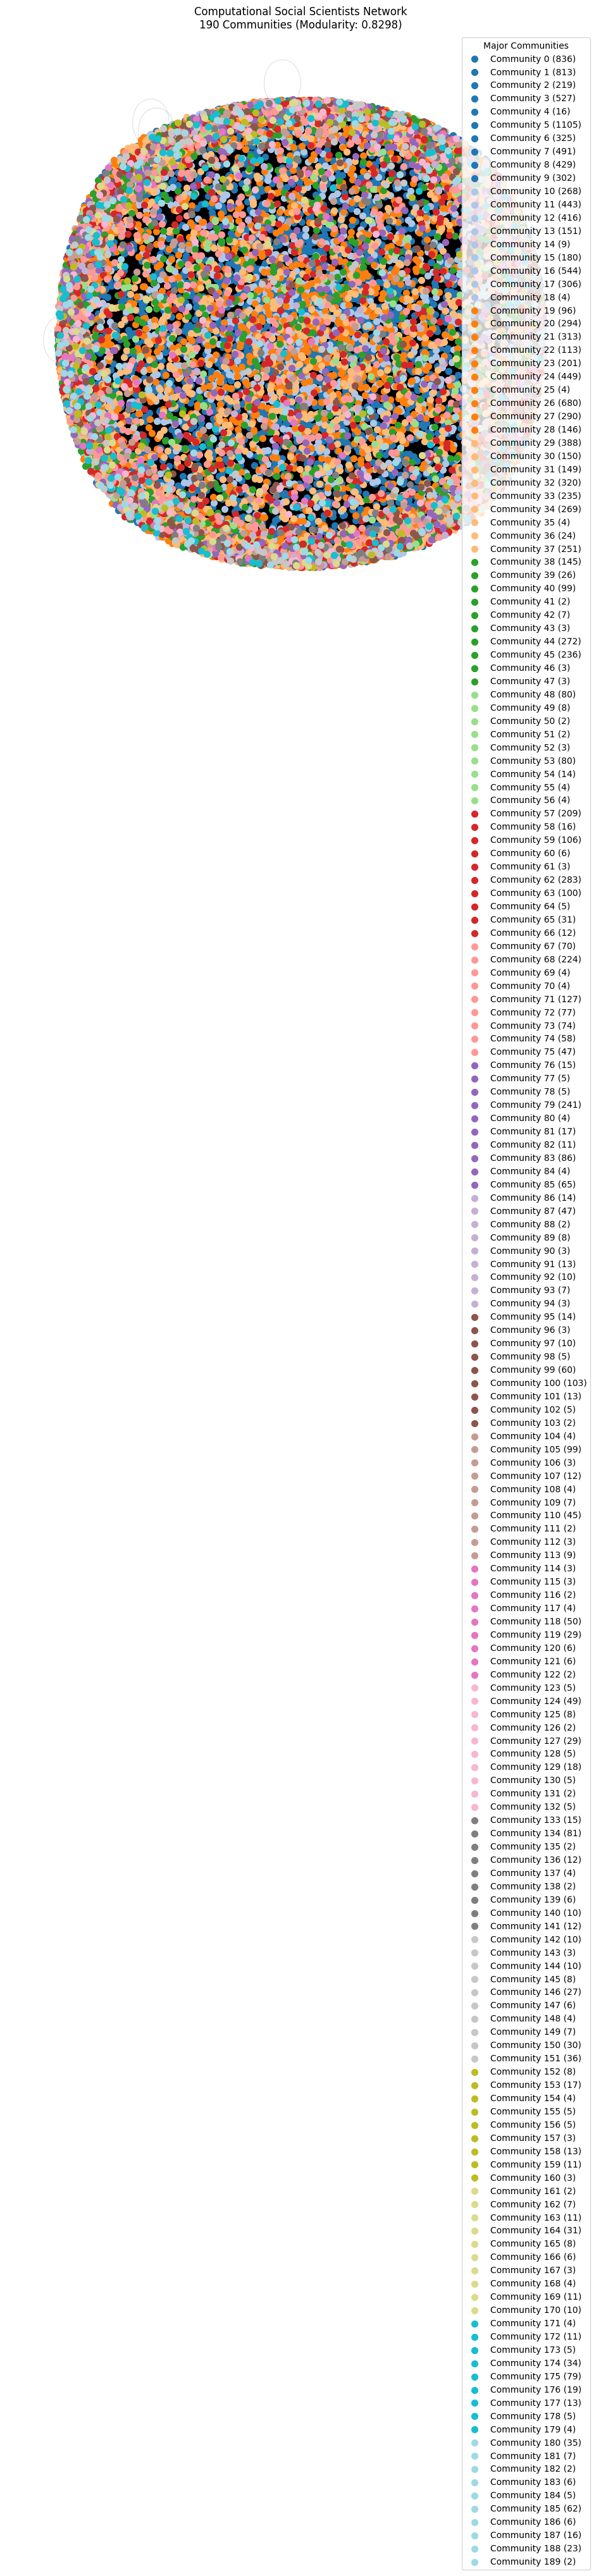


Community Statistics:
    community  size  avg_citations  total_citations top_country
5           5  1105            0.0                0          US
0           0   836            0.0                0          US
1           1   813            0.0                0          US
26         26   680            0.0                0          CN
16         16   544            0.0                0          US
3           3   527            0.0                0          US
7           7   491            0.0                0          US
24         24   449            0.0                0          US
11         11   443            0.0                0          US
8           8   429            0.0                0          US


In [68]:
from collections import Counter

# Apply the Louvain algorithm to find communities
partition = community_louvain.best_partition(researchers_graph)

# Calculate the modularity of this partition
modularity = community_louvain.modularity(partition, researchers_graph)
print(f"Modularity found by Louvain algorithm: {modularity:.4f}")

# Count communities and their sizes
community_sizes = Counter(partition.values())
num_communities = len(community_sizes)
print(f"Number of communities found: {num_communities}")

# Display community sizes in descending order
sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
print("\nCommunity sizes:")
for community_id, size in sorted_communities:
    print(f"Community {community_id}: {size} researchers")

# Assign community to each researcher in the graph
for node in researchers_graph.nodes():
    researchers_graph.nodes[node]['community'] = partition[node]

# Visualize the network with community colors
plt.figure(figsize=(12, 12))

# Set node positions using spring layout
pos = nx.spring_layout(researchers_graph, k=0.3, iterations=50, seed=42)

# Get unique communities for coloring
unique_communities = set(partition.values())
cmap = plt.cm.get_cmap("tab20", len(unique_communities))

# Draw nodes colored by community
for i, comm in enumerate(unique_communities):
    # Get nodes in community
    comm_nodes = [n for n in researchers_graph.nodes() if partition[n] == comm]
    
    # Draw nodes for this community
    nx.draw_networkx_nodes(researchers_graph, pos, 
                          nodelist=comm_nodes,
                          node_size=50,
                          node_color=[cmap(i)],
                          label=f"Community {comm} ({len(comm_nodes)})")

# Draw edges with transparency
nx.draw_networkx_edges(researchers_graph, pos, alpha=0.1)

# Add legend for larger communities only (top 10)
plt.legend(loc="upper right", title="Major Communities")

plt.title(f"Computational Social Scientists Network\n{num_communities} Communities (Modularity: {modularity:.4f})")
plt.axis('off')
plt.tight_layout()
plt.savefig("social_scientists_communities.png", dpi=300)
plt.show()

# Save the community assignments
community_data = []
for node in researchers_graph.nodes():
    if 'name' in researchers_graph.nodes[node]:
        community_data.append({
            'author_id': node,
            'name': researchers_graph.nodes[node].get('name', 'Unknown'),
            'country': researchers_graph.nodes[node].get('country', 'Unknown'),
            'community': partition[node],
            'citation_count': researchers_graph.nodes[node].get('citation_count', 0)
        })

community_df = pd.DataFrame(community_data)
community_df.to_csv("author_communities.csv", index=False)

# Calculate basic stats for each community
community_stats = community_df.groupby('community').agg({
    'author_id': 'count',
    'citation_count': ['mean', 'sum'],
    'country': lambda x: Counter(x).most_common(1)[0][0]
}).reset_index()

community_stats.columns = ['community', 'size', 'avg_citations', 'total_citations', 'top_country']
print("\nCommunity Statistics:")
print(community_stats.sort_values('size', ascending=False).head(10))